# Resampled PSFs from _JWST_/NIRCam Imaging

This example notebook shows how `spike` interacts with _JWST_/NIRCam imaging to generate a resampled PSF. This notebook uses observations the following files:
- jw02514162001_03201_00001_nrca2_cal.fits
- jw02514162001_03201_00002_nrca2_cal.fits
- jw02514162001_03201_00003_nrca2_cal.fits

The easiest way to find these data in the MAST archive is by searching for observation IDs jw02514162001_03201_00001_nrca2, jw02514162001_03201_00002_nrca2, jw02514162001_03201_00003_nrca2. `spike` uses calibrated, but not-yet co-added images (i.e., "Level 2" data products), so be sure that your download includes 'cal' files.

NOTE: Environment variables are not always read in properly within Jupyter notebooks/JupyterLab -- see [here](https://github.com/avapolzin/spike/blob/master/example_notebooks/README.md) for some additional details of how to access them.

In [1]:
from spike.psf import jwst # import the relevant top-level module from spike

datapath = '/path/to/nircam/data'
outputpath = 'psfs' #default is /psfs, defined from your working directory

Note that if you choose to create resampled PSFs for the same data and object location using multiple PSF generation methods, you will want to define a new 'savedir' each time to avoid conflicts between files with the same name.

We'll also define an object -- in this case, a set of coordinates -- for which the PSF will be generated.

In [2]:
obj = '10:00:31.432 +02:10:26.29' #can also be a resolvable name or coordinates in decimal degrees

Now, we can call `spike.psf.jwst` -- as an initial example we'll use the most minimal inputs. By default, in addition to saving drizzled PSFs and any intermediate products in the directory given by 'savedir' (here the argument will be the outputpath variable we definied), this function will return a dictionary that stores model PSFs indexed by filter and object. 

If `returnpsf = 'full'` (default), the arrays in the dictionary will be the full drizzled image field of view. If `returnpsf = 'crop'`, the arrays in the dictionary will be the cutout region around the object location with the size of the cutout determined by the 'cutout_fov' argument; the cropped region around the drizzled PSF will also be saved as a FITS file, including its WCS information (can be toggled off with `savecutout = False`).

`spike` assumes that the input files have not yet been "tweaked" and handles that step for you. If your input images have been tweaked _or_ if you would like to skip this step for other reasons, specify `pretweaked = True` in calling `spike.psf.jwst`. The _JWST_ pipeline replaces the suffix of the tweaked files, going from 'cal' to 'tweakregstep', if you tweak the files with `spike`. As such, in addition to `pretweaked = True`, it will be necessary to set `img_type = 'tweakregstep'`. The examples in this notebook follow this convention.

The outputs can be very long due to all of the print statements from the tweak, PSF generation, and resampling steps. Outputs have been cleared for cells where `spike.psf.jwst` was run.

In [ ]:
dpsf = jwst(img_dir = datapath, obj = obj, img_type = 'cal', inst = 'NIRCam',
           savedir = outputpath, pretweaked = False)

In this case dpsf will be very simple, since we are only looking at one set of coordinates and one filter:

In [4]:
dpsf

{'10:00:31.432 +02:10:26.29': {'F115W': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
        shape=(2080, 2077), dtype='>f4')}}

`spike` can automatically plot model PSFs as they are generated, and generates PSFs regardless of whether they are plotted (or returned). To show the output drizzled PSFs here, we will plot them directly. Therefore, we will import `matplotlib` below. Since `returnpsf = 'full'` by default, the array stored in dpsf shows the drizzled PSF in the context of the entire co-added image footprint. This is equivalent to reading in the image stored in '100031+021026_F115W_resamplestep.fits'.

Text(0, 0.5, 'y (pix)')

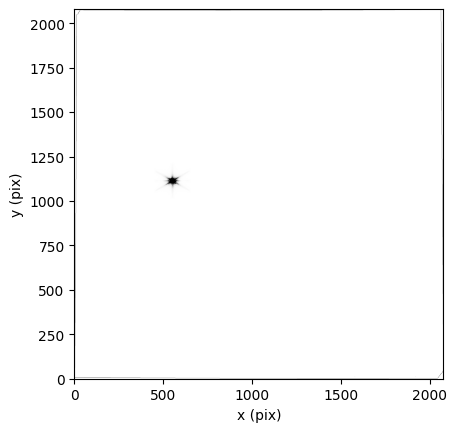

In [5]:
import matplotlib.pyplot as plt
import numpy as np

dat = dpsf['10:00:31.432 +02:10:26.29']['F115W']

fig = plt.figure()
plt.imshow(dat, vmin = np.nanpercentile(dat[dat != 0], 20), vmax = np.nanpercentile(dat[dat != 0], 97),
            origin = 'lower', cmap = 'Greys')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')

We can index the array to just show the PSF below:

Text(0, 0.5, 'y (pix)')

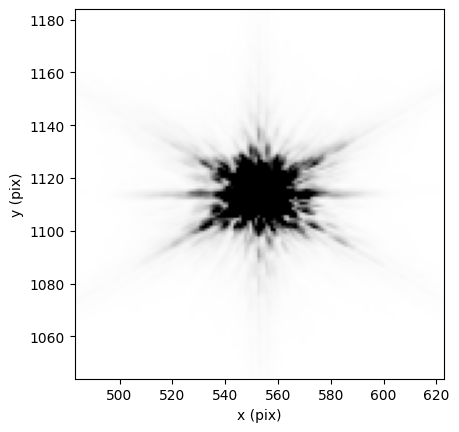

In [6]:
dat = dpsf['10:00:31.432 +02:10:26.29']['F115W'][1044: 1184, 483:623]

fig = plt.figure()
plt.imshow(dat, vmin = np.nanpercentile(dat[dat != 0], 20), vmax = np.nanpercentile(dat[dat != 0], 97),
            origin = 'lower', cmap = 'Greys', extent = [483, 623, 1044, 1184])
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')

By default, PSFs are generated for `spike.psf.jwst` by `WebbPSF` for a 6 arcsec x 6 arcsec region; users have complete control over the specifics of the PSF generation with keyword arguments for `spike.psfgen.jwpsf` and the optional dictionary `calckwargs` which is a keyword argument for `spike.psf.jwst` and feeds additional keyword arguments to `WebbPSF` when the it's called by `spike`. 

One advantage of `spike` is that it can be used flexibly with a variety of different PSF generation methods -- to change which one is used, simply use the 'method' argument. Built-in options are:
- 'WebbPSF’
- ‘STDPSF’
- ‘epsf’
- ‘PSFEx’

If `method = 'USER'`, then the keyword argument 'usermethod' must also be specified, pointing to either a function or a directory that houses model PSFs that follow the \[imgprefix]\_\[coords]\_\[band]\_topsf.fits, e.g., imgprefix_23.31+30.12_F814W_topsf.fits or imgprefix_195.78-46.52_F555W_topsf.fits naming scheme.

We'll use STDPSFs below and have `spike` output cutouts around the resampled PSF.

In [ ]:
dpsf = jwst(img_dir = datapath, obj = obj, img_type = 'tweakregstep', inst = 'NIRCam',
           method = 'STDPSF', savedir = outputpath, pretweaked = True)

In [8]:
dpsf

{'10:00:31.432 +02:10:26.29': {'F115W': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
        shape=(2080, 2077), dtype='>f4')}}

Text(0, 0.5, 'y (pix)')

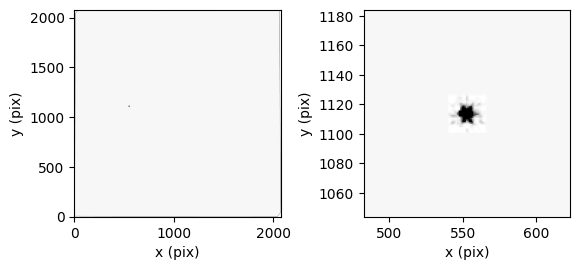

In [9]:
dat = dpsf['10:00:31.432 +02:10:26.29']['F115W']
datcrop = dpsf['10:00:31.432 +02:10:26.29']['F115W'][1044: 1184, 483:623]

fig, ax = plt.subplots(1, 2, gridspec_kw = {'wspace':0.4})
ax[0].imshow(dat, vmin = np.nanpercentile(dat[dat != 0], 20), vmax = np.nanpercentile(dat[dat != 0], 90),
            origin = 'lower', cmap = 'Greys')
ax[0].set_xlabel('x (pix)')
ax[0].set_ylabel('y (pix)')

ax[1].imshow(datcrop, origin = 'lower', cmap = 'Greys', extent = [483, 623, 1044, 1184],
             vmin = np.nanpercentile(datcrop[datcrop != 0], 20), 
             vmax = np.nanpercentile(datcrop[datcrop != 0], 90))
ax[1].set_xlabel('x (pix)')
ax[1].set_ylabel('y (pix)')

`spike` can also be used to generate PSFs for multiple objects/coordinates simultaneously. We'll do this using the default `WebbPSF` parameters below.

In [ ]:
obj = ['10:00:31.432 +02:10:26.29', '10:00:31.0132 +02:09:53.23']

dpsf = jwst(img_dir = datapath, obj = obj, img_type = 'tweakregstep', inst = 'NIRCam',
           savedir = outputpath, pretweaked = True, returnpsf = 'crop')

In [12]:
dpsf

{'10:00:31.432 +02:10:26.29': {'F115W': array([[1.37165355e-08, 1.16727819e-08, 1.33040219e-08, ...,
          4.02859328e-08, 3.59869610e-08, 3.28664029e-08],
         [1.65953118e-08, 1.43423229e-08, 1.25833477e-08, ...,
          4.12311536e-08, 3.79603335e-08, 3.89721677e-08],
         [1.84145463e-08, 1.79218329e-08, 1.58013744e-08, ...,
          4.06137133e-08, 4.09517433e-08, 4.18358930e-08],
         ...,
         [3.83971290e-08, 3.83771841e-08, 3.44180719e-08, ...,
          1.55508868e-08, 1.90290628e-08, 2.28565380e-08],
         [3.66434811e-08, 3.28258913e-08, 2.74249743e-08, ...,
          1.52441846e-08, 1.50736046e-08, 1.89214298e-08],
         [3.07511030e-08, 2.62706230e-08, 2.68563127e-08, ...,
          1.78912902e-08, 1.42374823e-08, 1.39539580e-08]],
        shape=(151, 151), dtype='>f4')},
 '10:00:31.0132 +02:09:53.23': {'F115W': array([[1.2495302e-08, 1.2049310e-08, 1.5706604e-08, ..., 3.6155981e-08,
          3.2709121e-08, 3.3963385e-08],
         [1.5624083

Since we've selected `returnpsf = 'crop'`, the output array is already cropped to the immediate region around the PSF. Selecting both `returnpsf = 'crop'` and `savecutout = True` (default), will save a FITS file that stores the cropped resampled PSF -- the name is the same as the for the full saved image with '_crop' appended.

Text(0, 0.5, 'y (pix)')

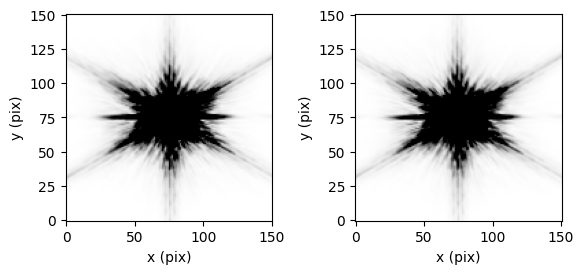

In [13]:
dat = dpsf['10:00:31.432 +02:10:26.29']['F115W']

fig, ax = plt.subplots(1, 2, gridspec_kw = {'wspace':0.4})
ax[0].imshow(dat, vmin = np.nanpercentile(dat[dat != 0], 20), vmax = np.nanpercentile(dat[dat != 0], 90),
            origin = 'lower', cmap = 'Greys')
ax[0].set_xlabel('x (pix)')
ax[0].set_ylabel('y (pix)')

dat = dpsf['10:00:31.0132 +02:09:53.23']['F115W']

ax[1].imshow(dat, vmin = np.nanpercentile(dat[dat != 0], 20), vmax = np.nanpercentile(dat[dat != 0], 90), 
            origin = 'lower', cmap = 'Greys',)
ax[1].set_xlabel('x (pix)')
ax[1].set_ylabel('y (pix)')